
# **USD/AUD PPP + CIP — Unified Econometrics & ML Notebook**
*Author: Hannan Nabi*

This notebook integrates:
1. **PPP (Purchasing Power Parity)** — inflation differential vs. exchange rate changes (econometrics + ML)
2. **CIP (Covered Interest Parity)** — interest rate parity, theoretical forward, and deviation (econometrics + ML)
3. **Unified ML** — combines PPP & CIP signals with lags, uses rolling-origin backtests and baselines

> **How to use:** If your dataframes are already created in-session (e.g., `df` for PPP and `df_cip` for CIP), this notebook will detect and merge them. Otherwise, point the CSV paths in the **Data Loading** cell.


In [1]:

# ===== Imports & Config =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Econometrics
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

# ML
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score
)

# Ensure plots display
%matplotlib inline



## 1) Data Loading

- If your session already has PPP dataframe (e.g., `df`) and CIP dataframe (e.g., `df_cip`), the cell below will use them.
- Otherwise, set the CSV paths accordingly.


In [3]:
# ===== Data Loading (via FRED) =====
import pandas_datareader.data as web
import pandas as pd
import numpy as np

start = '2010-01-01'
end   = '2024-12-31'

# === 1. Download PPP-related data ===
# USD per AUD exchange rate
fx = web.DataReader('DEXUSAL', 'fred', start, end)

# US and Australia CPI indices (monthly)
cpi_us = web.DataReader('CPIAUCSL', 'fred', start, end)           # US CPI (Index)
cpi_aus = web.DataReader('AUSPCPIPCPPPT', 'fred', start, end)     # AUS CPI (Index)

# Combine
df_ppp = pd.concat([fx, cpi_us, cpi_aus], axis=1)
df_ppp.columns = ['DEXUSAL', 'CPI_US', 'CPI_AUS']
df_ppp = df_ppp.ffill().dropna()

# Compute inflation rates (% monthly change, annualized)
df_ppp['pi_US']  = 100 * (df_ppp['CPI_US'].pct_change() * 12)
df_ppp['pi_AUS'] = 100 * (df_ppp['CPI_AUS'].pct_change() * 12)
df_ppp['infl_diff'] = df_ppp['pi_US'] - df_ppp['pi_AUS']

# Exchange rate log change (% approx)
df_ppp['dln_exch'] = 100 * np.log(df_ppp['DEXUSAL'] / df_ppp['DEXUSAL'].shift(1))

df_ppp = df_ppp.dropna()

# === 2. Download CIP-related data ===
# Short-term interest rates (3-Month interbank or equivalent)
r_us = web.DataReader('IR3TIB01USM156N', 'fred', start, end)  # US 3M Interbank
r_au = web.DataReader('IR3TIB01AUM156N', 'fred', start, end)  # AUS 3M Interbank

df_cip = pd.concat([r_us, r_au], axis=1)
df_cip.columns = ['r_us', 'r_au']
df_cip = df_cip.ffill().dropna()

# Convert to decimal annualized rates
df_cip = df_cip / 100

# === 3. Merge PPP + CIP ===
df_all = pd.merge(df_ppp, df_cip, left_index=True, right_index=True, how='inner')

# === 4. Display summary ===
print("PPP rows:", len(df_ppp), "| CIP rows:", len(df_cip), "| Merged rows:", len(df_all))
print("Date range:", df_all.index.min().date(), "to", df_all.index.max().date())
df_all.head()


PPP rows: 3961 | CIP rows: 180 | Merged rows: 179
Date range: 2010-02-01 to 2024-12-01


,DEXUSAL,CPI_US,CPI_AUS,pi_US,pi_AUS,infl_diff,dln_exch,r_us,r_au
DATE,,,,,,,,,
2010-02-01,0.8877,217.281,2.645503,-1.142132,0.0,-1.142132,0.045070,0.0019,0.0416
2010-03-01,0.9001,217.353,2.645503,0.397642,0.0,0.397642,0.445385,0.0023,0.0433
2010-04-01,0.9212,217.403,2.645503,0.276049,0.0,0.276049,0.467875,0.0030,0.0455
2010-05-01,0.9306,217.290,2.645503,-0.623726,0.0,-0.623726,0.000000,0.0045,0.0481
2010-06-01,0.8396,217.199,2.645503,-0.502554,0.0,-0.502554,-1.125138,0.0052,0.0489



## 2) PPP Section (Econometrics + Quick ML)

We regress the change in the exchange rate on the inflation differential, then contrast with simple ML variants.


                            OLS Regression Results                            
Dep. Variable:               dln_exch   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.3849
Date:                Mon, 10 Nov 2025   Prob (F-statistic):              0.536
Time:                        17:52:13   Log-Likelihood:                -159.83
No. Observations:                 179   AIC:                             323.7
Df Residuals:                     177   BIC:                             330.0
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0200      0.045      0.448      0.6

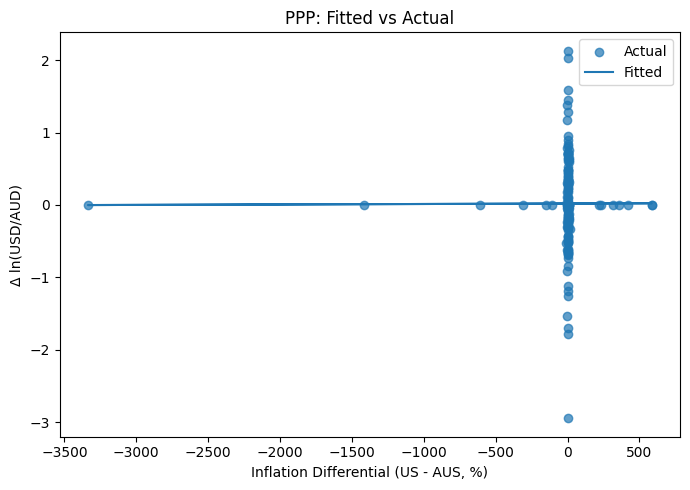

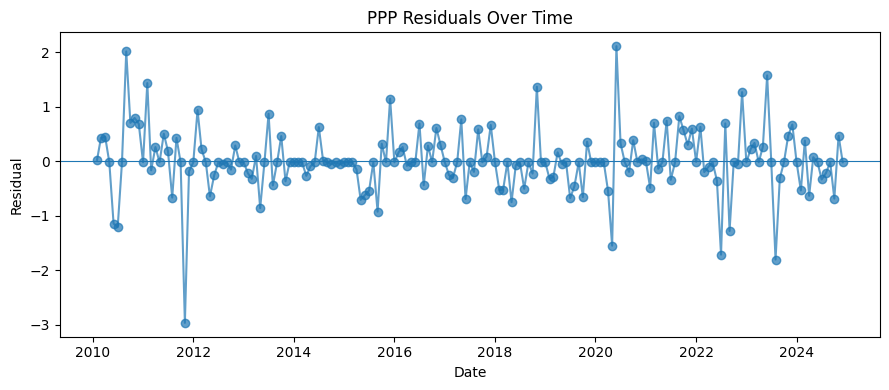

In [4]:

# ===== PPP OLS Regression =====
X = sm.add_constant(df_all['infl_diff'])
y = df_all['dln_exch']

ols_ppp = sm.OLS(y, X).fit(cov_type='HC3')
print(ols_ppp.summary())

dw_stat = sm.stats.durbin_watson(ols_ppp.resid)
print(f"Durbin–Watson: {dw_stat:.3f}")

# Fitted vs Actual (scatter + line)
plt.figure(figsize=(7,5))
plt.scatter(df_all['infl_diff'], df_all['dln_exch'], alpha=0.7, label='Actual')
plt.plot(df_all['infl_diff'], ols_ppp.predict(X), label='Fitted')
plt.title('PPP: Fitted vs Actual')
plt.xlabel('Inflation Differential (US - AUS, %)')
plt.ylabel('Δ ln(USD/AUD)')
plt.legend()
plt.tight_layout()
plt.show()

# Residual plot
plt.figure(figsize=(9,4))
plt.plot(df_all.index, ols_ppp.resid, marker='o', alpha=0.7)
plt.axhline(0, linewidth=0.8)
plt.title('PPP Residuals Over Time')
plt.xlabel('Date'); plt.ylabel('Residual')
plt.tight_layout(); plt.show()


In [5]:

# ===== PPP Quick ML (Ridge, Lasso, RF) - In-sample comparison =====
X_ml = df_all[['infl_diff']].values
y_ml = df_all['dln_exch'].values

tscv = TimeSeriesSplit(n_splits=5)

# Ridge / Lasso with scaling
ridge = Pipeline([('scaler', StandardScaler()), ('model', RidgeCV(alphas=np.logspace(-3,3,30), cv=tscv))])
lasso = Pipeline([('scaler', StandardScaler()), ('model', LassoCV(alphas=np.logspace(-3,3,30), cv=tscv, max_iter=10000))])
rf = RandomForestRegressor(n_estimators=300, random_state=42)

models = {'OLS_PPP': ols_ppp, 'Ridge': ridge, 'Lasso': lasso, 'RandomForest': rf}

results = []
# OLS in-sample metrics
ols_pred = ols_ppp.predict(sm.add_constant(df_all['infl_diff']))
results.append({'Model':'OLS_PPP', 'R2': r2_score(y_ml, ols_pred), 'RMSE': np.sqrt(mean_squared_error(y_ml, ols_pred))})

# ML models
for name, est in [('Ridge', ridge), ('Lasso', lasso), ('RandomForest', rf)]:
    est.fit(X_ml, y_ml)
    yhat = est.predict(X_ml)
    results.append({'Model': name, 'R2': r2_score(y_ml, yhat), 'RMSE': np.sqrt(mean_squared_error(y_ml, yhat))})

pd.DataFrame(results)


,Model,R2,RMSE
0,OLS_PPP,0.000009,0.590945
1,Ridge,0.000003,0.590947
2,Lasso,0.000000,0.590948
3,RandomForest,0.825722,0.246701



## 3) CIP Section (Parity Construction + Diagnostics)

We construct the theoretical forward via interest parity and compute deviations.


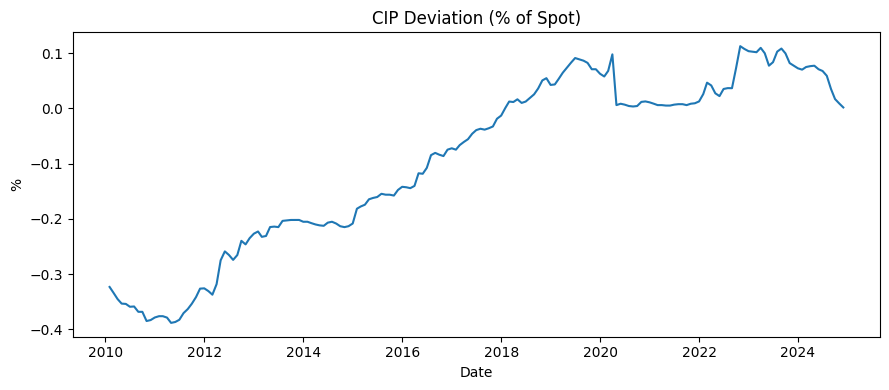

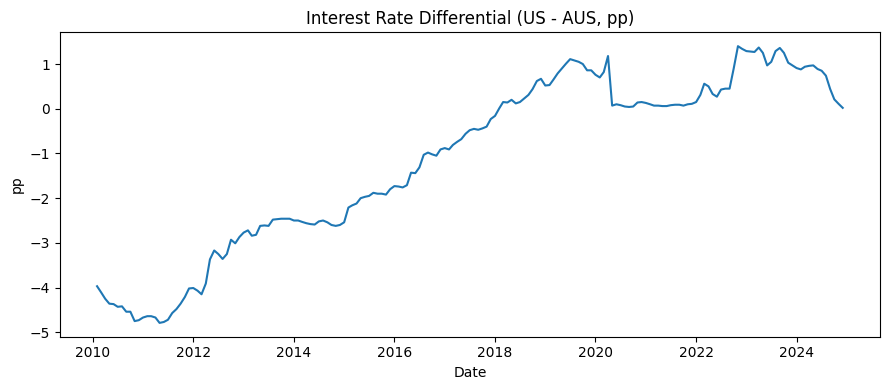

In [6]:

# ===== CIP Construction =====
# Convert annualized rates to monthly (approx. compounding)
r_us_m = (1 + df_all['r_us']).pow(1/12) - 1
r_au_m = (1 + df_all['r_au']).pow(1/12) - 1

S_t = df_all['DEXUSAL']
F_cip = S_t * (1 + r_us_m) / (1 + r_au_m)

df_all['cip_dev_pct'] = (F_cip - S_t) / S_t * 100.0
df_all['int_diff'] = (df_all['r_us'] - df_all['r_au']) * 100.0  # percentage points

# Quick visuals
plt.figure(figsize=(9,4))
plt.plot(df_all.index, df_all['cip_dev_pct'])
plt.title('CIP Deviation (% of Spot)')
plt.xlabel('Date'); plt.ylabel('%')
plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4))
plt.plot(df_all.index, df_all['int_diff'])
plt.title('Interest Rate Differential (US - AUS, pp)')
plt.xlabel('Date'); plt.ylabel('pp')
plt.tight_layout(); plt.show()



## 4) Long-Run PPP (Cointegration)


In [7]:

# ===== Engle–Granger Cointegration Test =====
df_coint = df_all[['DEXUSAL', 'CPI_US', 'CPI_AUS']].dropna() if {'CPI_US','CPI_AUS'}.issubset(df_all.columns) else None
if df_coint is not None and len(df_coint) > 10:
    score, pval, _ = coint(np.log(df_coint['DEXUSAL']), np.log(df_coint['CPI_US'] / df_coint['CPI_AUS']))
    print(f"Engle–Granger cointegration p-value: {pval:.4f}")
    if pval < 0.05:
        print("Long-run PPP holds (cointegrated).")
    else:
        print("No long-run PPP evidence (not cointegrated).")
else:
    print("Skipping cointegration test: CPI columns missing in merged frame or insufficient data.")


Engle–Granger cointegration p-value: 0.8728
No long-run PPP evidence (not cointegrated).



## 5) Unified ML on PPP + CIP Signals (with Lags)
We combine PPP and CIP features and evaluate models with time-series CV and a rolling-origin backtest.


In [8]:

# ===== Feature Engineering for Unified ML =====
df_all['lag_dln_exch_1'] = df_all['dln_exch'].shift(1)
df_all['lag_dln_exch_2'] = df_all['dln_exch'].shift(2)
df_all['lag_infl_diff_1'] = df_all['infl_diff'].shift(1)
df_all['lag_cip_dev_1']   = df_all['cip_dev_pct'].shift(1)

features = [
    'infl_diff', 'int_diff', 'cip_dev_pct',
    'lag_dln_exch_1', 'lag_dln_exch_2',
    'lag_infl_diff_1', 'lag_cip_dev_1'
]

df_ml = df_all[features + ['dln_exch']].dropna().copy()
X = df_ml[features].values
y = df_ml['dln_exch'].values

tscv = TimeSeriesSplit(n_splits=5)

ridge_u = Pipeline([('scaler', StandardScaler()), ('model', RidgeCV(alphas=np.logspace(-3,3,30), cv=tscv))])
lasso_u = Pipeline([('scaler', StandardScaler()), ('model', LassoCV(alphas=np.logspace(-3,3,30), cv=tscv, max_iter=10000))])
rf_u = RandomForestRegressor(n_estimators=400, random_state=42, min_samples_leaf=2)
xgb_u = XGBRegressor(n_estimators=500, learning_rate=0.03, max_depth=3, subsample=0.8, colsample_bytree=0.8, random_state=42)

models_u = {'Ridge': ridge_u, 'Lasso': lasso_u, 'RandomForest': rf_u, 'XGBoost': xgb_u}

cv_rows = []
for name, est in models_u.items():
    neg_mse = cross_val_score(est, X, y, cv=tscv, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-neg_mse.mean())
    cv_rows.append({'Model': name, 'CV_RMSE': rmse})
cv_df = pd.DataFrame(cv_rows).sort_values('CV_RMSE')
print("=== Time-Series CV (Unified PPP+CIP) ===")
print(cv_df.round(4))


=== Time-Series CV (Unified PPP+CIP) ===
          Model  CV_RMSE
1         Lasso   0.5286
0         Ridge   0.5315
2  RandomForest   0.5744
3       XGBoost   0.6591


In [9]:

# ===== Rolling-Origin Backtest (1-step ahead) =====
h = 1
start_frac = 0.6
start_idx = int(len(df_ml) * start_frac)

def backtest(estimator, X, y, start_idx, h=1):
    preds, truths = [], []
    for t in range(start_idx, len(y)-h+1):
        X_train, y_train = X[:t], y[:t]
        X_test, y_test = X[t:t+h], y[t:t+h]
        import copy
        est = copy.deepcopy(estimator)
        est.fit(X_train, y_train)
        y_hat = est.predict(X_test)
        preds.extend(np.array(y_hat).ravel().tolist())
        truths.extend(np.array(y_test).ravel().tolist())
    preds = np.array(preds); truths = np.array(truths)
    mae = mean_absolute_error(truths, preds)
    rmse = np.sqrt(mean_squared_error(truths, preds))
    return mae, rmse, preds, truths

bt_rows = []
bt_store = {}
for name, est in models_u.items():
    mae, rmse, yhat, ytrue = backtest(est, X, y, start_idx, h=h)
    bt_rows.append({'Model': name, 'MAE': mae, 'RMSE': rmse})
    bt_store[name] = (yhat, ytrue)

# Random Walk baseline: predict zero change
ytrue_rw = bt_store[list(bt_store.keys())[0]][1]
yhat_rw = np.zeros_like(ytrue_rw)
mae_rw  = mean_absolute_error(ytrue_rw, yhat_rw)
rmse_rw = np.sqrt(mean_squared_error(ytrue_rw, yhat_rw))
bt_rows.append({'Model': 'RandomWalk', 'MAE': mae_rw, 'RMSE': rmse_rw})

bt_df = pd.DataFrame(bt_rows).sort_values('RMSE')
print("=== Rolling Backtest (1-step ahead) ===")
print(bt_df.round(4))

# Plot actual vs best model (by RMSE)
best_model = bt_df.iloc[0]['Model']
yhat_best, ytrue_best = bt_store.get(best_model, (None, None))
if yhat_best is not None:
    plt.figure(figsize=(9,4))
    plt.plot(ytrue_best, label='Actual')
    plt.plot(yhat_best, label=f'Predicted ({best_model})')
    plt.title('Rolling Forecast: Actual vs Predicted')
    plt.xlabel('Test Steps'); plt.ylabel('Δ ln(USD/AUD)')
    plt.legend(); plt.tight_layout(); plt.show()


=== Rolling Backtest (1-step ahead) ===
          Model     MAE    RMSE
4    RandomWalk  0.3956  0.6219
1         Lasso  0.4010  0.6239
0         Ridge  0.4029  0.6283
2  RandomForest  0.4377  0.6555
3       XGBoost  0.4807  0.7012



## 6) Descriptive Annual Summary (Optional)


/tmp/ipython-input-2493882461.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_annual = df_all.resample('Y').mean().copy()


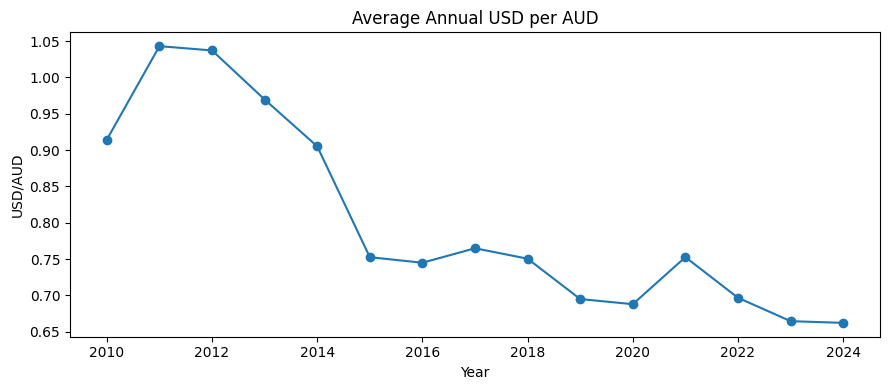

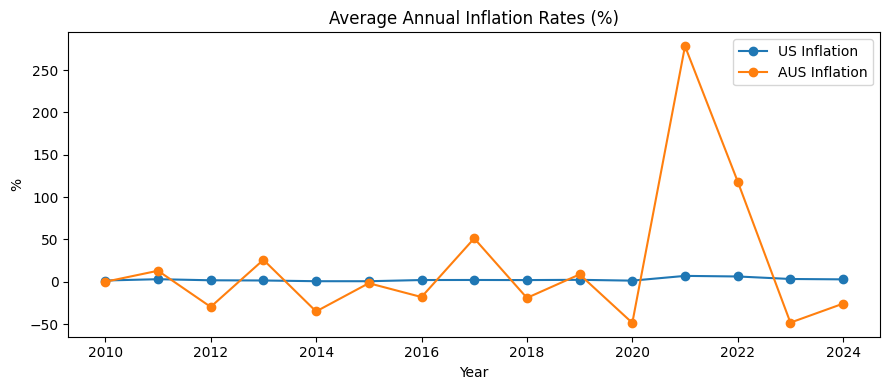

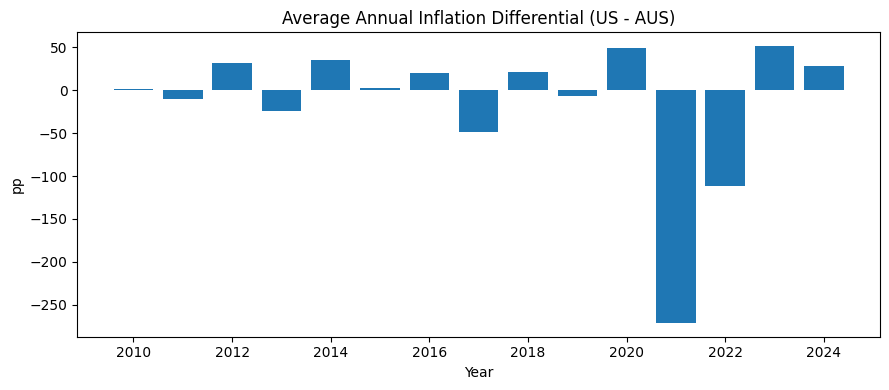

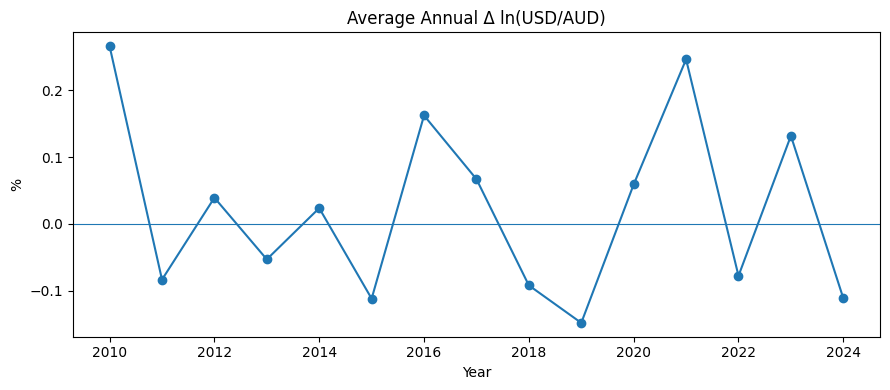

In [10]:

# Ensure datetime index for resampling
df_all.index = pd.to_datetime(df_all.index)

df_annual = df_all.resample('Y').mean().copy()

plt.figure(figsize=(9,4))
plt.plot(df_annual.index.year, df_annual['DEXUSAL'], marker='o')
plt.title('Average Annual USD per AUD')
plt.xlabel('Year'); plt.ylabel('USD/AUD'); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4))
plt.plot(df_annual.index.year, df_annual['pi_US'], marker='o', label='US Inflation')
plt.plot(df_annual.index.year, df_annual['pi_AUS'], marker='o', label='AUS Inflation')
plt.title('Average Annual Inflation Rates (%)')
plt.xlabel('Year'); plt.ylabel('%')
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4))
plt.bar(df_annual.index.year, df_annual['infl_diff'])
plt.title('Average Annual Inflation Differential (US - AUS)')
plt.xlabel('Year'); plt.ylabel('pp'); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4))
plt.plot(df_annual.index.year, df_annual['dln_exch'], marker='o')
plt.axhline(0, linewidth=0.8)
plt.title('Average Annual Δ ln(USD/AUD)')
plt.xlabel('Year'); plt.ylabel('%'); plt.tight_layout(); plt.show()



## 7) Quick Interpretation Notes

- **PPP (OLS)**: Tests whether inflation differentials explain short-run exchange rate changes.
- **CIP**: Constructs theoretical forward via interest parity and measures deviations; useful as a market-based signal.
- **Unified ML**: Combines PPP & CIP features with lags to capture nonlinearities and regime effects. Evaluated with **time-series CV** and a **rolling-origin** backtest, and compared against a **Random Walk**.
- If **Random Walk** still wins out-of-sample, that aligns with FX literature: short-run FX is hard to beat; PPP/CIP act as anchors more than predictors.
